In [1]:
# --- Install necessary libraries if running on Google Colab for the first time ---
!pip install pandas numpy scikit-learn matplotlib seaborn umap-learn shap

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import shap

In [2]:
# --- 1. Import the CSV files ---

from google.colab import files
uploaded = files.upload()

cerebellum_df = pd.read_csv('cerebellum_DP.csv')
hippocampus_df = pd.read_csv('Hippocampus_DP.csv')
thalamus_df = pd.read_csv('Thallamus_DP.csv')
dpfc_df = pd.read_csv('DPFC_DP.csv')

# Drop the 'AdjustedPvalue' column as requested
cerebellum_df = cerebellum_df.drop('AdjustedPvalue', axis=1, errors='ignore')
hippocampus_df = hippocampus_df.drop('AdjustedPvalue', axis=1, errors='ignore')
thalamus_df = thalamus_df.drop('AdjustedPvalue', axis=1, errors='ignore')
dpfc_df = dpfc_df.drop('AdjustedPvalue', axis=1, errors='ignore')

# Display the first few rows of each DataFrame to verify import
print("\n--- Cerebellum Data ---")
print(cerebellum_df.head())
print("\n--- Hippocampus Data ---")
print(hippocampus_df.head())
print("\n--- Thalamus Data ---")
print(thalamus_df.head())
print("\n--- DPFC Data ---")
print(dpfc_df.head())

Saving Thallamus_DP.csv to Thallamus_DP.csv
Saving cerebellum_DP.csv to cerebellum_DP.csv
Saving DPFC_DP.csv to DPFC_DP.csv
Saving Hippocampus_DP.csv to Hippocampus_DP.csv

--- Cerebellum Data ---
   Accession     Gene    22week_Avg    26week_Avg     1year_Avg     2year_Avg  \
0  194595509   SPTAN1  3.403840e+07  3.919413e+07  9.294157e+07  8.739405e+07   
1  306966132   SPTAN1  4.195606e+04  3.812966e+04  5.112267e+04  4.313739e+04   
2  112382250   SPTBN1  2.644566e+07  2.713649e+07  5.056949e+07  5.641060e+07   
3   41322908     PLEC  1.892782e+07  2.540079e+07  1.675443e+07  2.700018e+07   
4   33350932  DYNC1H1  3.015181e+07  2.807374e+07  2.422420e+07  2.308685e+07   

      4year_Avg    22year_Avg    35year_Avg    47year_Avg    82year_Avg  
0  9.942501e+07  9.608898e+07  7.419488e+07  7.729604e+07  7.943433e+07  
1  5.185106e+04  4.920949e+04  6.345708e+04  7.081324e+04  5.019671e+04  
2  6.209550e+07  5.938049e+07  5.729526e+07  5.229569e+07  5.309978e+07  
3  1.748658e+07  1.5

In [16]:
# Step 1: Upload the TSV file
from google.colab import files
import pandas as pd
import io
import re

uploaded = files.upload()

filename = list(uploaded.keys())[0]
with open(filename, 'r') as f:
    lines = f.readlines()

split_lines = [re.split(r'\t+', line.strip()) for line in lines]
max_len = max(len(row) for row in split_lines)
padded_lines = [row + [''] * (max_len - len(row)) for row in split_lines]

df = pd.DataFrame(padded_lines)
kegg_human_df = df.T

kegg_human_df.head()
kegg_human_df.columns = kegg_human_df.iloc[0]
kegg_human_df = kegg_human_df.drop(kegg_human_df.index[0])
print(kegg_human_df.columns)
kegg_human_df.to_csv('kegg_human.csv', index=False)

Saving gene sets for parkinson.gmt to gene sets for parkinson.gmt
Index(['Parkinson Disease Markers In Human Substantia Nigra GSE26927',
       'Genes Up-Regulated In Parkinson Disease Markers In Human Substantia Nigra GSE26927',
       'Genes Down-Regulated In Parkinson Disease Markers In Human Substantia Nigra GSE26927'],
      dtype='object', name=0)


In [17]:
parkinson_kegg_down = kegg_human_df['Genes Down-Regulated In Parkinson Disease Markers In Human Substantia Nigra GSE26927'].dropna().unique().tolist()
parkinson_kegg_up = kegg_human_df['Genes Up-Regulated In Parkinson Disease Markers In Human Substantia Nigra GSE26927'].dropna().unique().tolist()

if 'HDSigDB_Human_2021' in parkinson_kegg_down:
    parkinson_kegg_down.remove('HDSigDB_Human_2021')
if 'HDSigDB_Human_2021' in parkinson_kegg_up:
    parkinson_kegg_up.remove('HDSigDB_Human_2021')

print(parkinson_kegg_up)
print(len(parkinson_kegg_up))

print(parkinson_kegg_down)
print(len(parkinson_kegg_down))



['LRRC1', 'MGAT1', 'FBXL6', 'AFAP1L1', 'SF1', 'PCSK7', 'WDR24', 'TLN1', 'HPN', 'CDAN1', 'LIG1', 'PTBP1', 'NPC1', 'ZC3H18', 'TAF1C', 'ELF4', 'HYAL2', 'CNPY3', 'DFFB', 'TFEB', 'ISYNA1', 'RNF166', 'FGD3', 'P2RX7', 'CLDN9', 'MBP', 'PKN3', 'SH2D3C', 'CREB3L2', 'PARP10', 'CD37', 'PRAM1', 'TMEM170A', 'MFNG', 'RHBDF2', 'CIDEB', 'TPD52L2', 'NCOR2', 'FOXS1', 'SEMA4D', 'TPCN1', 'PGBD2', 'PLIN3', 'ACSS2', 'SLC22A23', 'MAP7D1', 'PACS2', 'TMEM63A', 'CSF1R', 'TBC1D10C', 'CARD9', 'SPTBN5', 'KCTD5', 'TRIM56', 'CBFA2T2', 'ARHGAP22', 'IRF5', 'LTBP3', 'WDR81', 'SYK', 'NCF4', 'ASPRV1', 'PUS1', 'GNAI2', 'PHB', 'CMKLR1', 'GMEB2', 'PLEKHG3', 'DGKD', 'NADK', 'REPIN1', 'TRABD', 'TNFAIP1', 'FGR', 'TRAF4', 'CTCF', 'ZFYVE26', 'SH2B3', 'GUCA1B', 'GGA2', 'MBTPS1', 'ADORA3', 'NKX6-2', 'FAM53B', 'POLG', 'ENPP6', 'TAGLN2', 'CREBBP', 'LAMA5', 'ACTR5', 'BCAT2', 'SLC15A4', 'CBX4', 'GSN', 'RASGRP2', 'INF2', 'ABHD15', 'DOCK10', 'CNNM3', 'LYG1', 'SATB2', 'ATG16L1', 'PHLPP1', 'NFASC', 'FMO3', 'LBR', 'SOX17', 'MCM3', 'TRAM2', 

In [11]:
dyregulated_genes = ["ELF1", "BCAR3", "BCL2", "GRAMD1C", "NWD1", "HLA-DRA", "HLA-DPA1", "TREM2", "C12orf59","TGFBR2", "RBM4B", "SLC7A9", "CD37", "IL13RA1", "PECAM1", "TUBA1C", "SMPD1", "TDRD5","ALDH1A1", "RGS22", "CD74", "CLDN1", "MS4A6A", "CPVL", "GUCA1A", "TP53INP2", "CLDN15","HLA-DRB4", "ADAMTS9", "RFX4 v3", "SUSD1", "ME3", "RUNX3", "DNAJB6", "EGR1", "TMEM27","CHP2", "SLITRK5", "CYP2J2", "LINGO1", "SLC14A1", "SST", "ANXA1", "CSDA", "IL17RB", "TNFRSF1A", "HES6", "MS4A7", "TIMP1", "SLC7A7", "PARVG", "ALOX5AP", "LCP1", "TYROBP","MT1G", "S100A4", "LPL", "CTGF", "LRCH4", "AP1G2", "CYBA"]
print(len(dyregulated_genes))

61


In [18]:
stage_groups = {
    'Prenatal': ['22week', '26week'],
    'Infant': ['1year', '2year'],
    'Child': ['4year'],
    'Adult': ['22year', '35year', '47year'],
    'Geriatric': ['82year']
}
stage_columns = ['22week_Avg', '26week_Avg', '1year_Avg', '2year_Avg', '4year_Avg', '22year_Avg', '35year_Avg', '47year_Avg', '']

brain_regions = {'Cerebellum': cerebellum_df,
                    'Hippocampus': hippocampus_df,
                    'Thalamus': thalamus_df,
                    'DPFC': dpfc_df}
trend_dfs = {}
for region, df in brain_regions.items():
    df = df.copy()
    df['Prenatal'] = df[['22week_Avg', '26week_Avg']].mean(axis=1)
    df['Infant'] = df[['1year_Avg', '2year_Avg']].mean(axis=1)
    df['Child'] = df['4year_Avg']
    df['Adult'] = df[['22year_Avg', '35year_Avg', '47year_Avg']].mean(axis=1)
    df['Geriatric'] = df['82year_Avg']

    group_df = df[['Gene', 'Accession', 'Prenatal', 'Infant', 'Child', 'Adult', 'Geriatric']].copy()
    print(group_df.head())

    fold_change = group_df[['Prenatal', 'Infant', 'Child', 'Adult', 'Geriatric']].divide(group_df['Prenatal'], axis=0)

    fold_change['Gene'] = group_df['Gene']
    fold_change['Accession'] = group_df['Accession']

    trend_dfs[region] = fold_change
    print(trend_dfs[region].head())


      Gene  Accession      Prenatal        Infant         Child         Adult  \
0   SPTAN1  194595509  3.661627e+07  9.016781e+07  9.942501e+07  8.252664e+07   
1   SPTAN1  306966132  4.004286e+04  4.713003e+04  5.185106e+04  6.115994e+04   
2   SPTBN1  112382250  2.679107e+07  5.349005e+07  6.209550e+07  5.632382e+07   
3     PLEC   41322908  2.216430e+07  2.187730e+07  1.748658e+07  1.697103e+07   
4  DYNC1H1   33350932  2.911277e+07  2.365552e+07  2.432593e+07  2.414903e+07   

      Geriatric  
0  7.943433e+07  
1  5.019671e+04  
2  5.309978e+07  
3  2.069531e+07  
4  2.011240e+07  
   Prenatal    Infant     Child     Adult  Geriatric     Gene  Accession
0       1.0  2.462507  2.715323  2.253824   2.169373   SPTAN1  194595509
1       1.0  1.176990  1.294889  1.527362   1.253575   SPTAN1  306966132
2       1.0  1.996562  2.317768  2.102335   1.981995   SPTBN1  112382250
3       1.0  0.987051  0.788953  0.765692   0.933723     PLEC   41322908
4       1.0  0.812548  0.835576  0.82950

In [21]:
print(cerebellum_df.shape, hippocampus_df.shape, thalamus_df.shape, dpfc_df.shape)
for region in brain_regions:
  print(trend_dfs[region].shape)
  #print(trend_dfs[region].head())

(4419, 11) (4383, 11) (4064, 11) (5633, 11)
(4419, 7)
(4383, 7)
(4064, 7)
(5633, 7)


In [22]:

def classify_trend(values, window=3):
    def smooth(arr, w):
        if len(arr) < w:
            return arr
        return np.convolve(arr, np.ones(w)/w, mode='valid')
    smoothed = smooth(values, window)
    if all(smoothed[i] <= smoothed[i+1] for i in range(len(smoothed)-1)):
        return 'increasing'
    elif all(smoothed[i] >= smoothed[i+1] for i in range(len(smoothed)-1)):
        return 'decreasing'
    else:
        return 'other'
groups_order = ['Prenatal', 'Infant', 'Child', 'Adult', 'Geriatric']


for region, df in trend_dfs.items():
    fold_change = df.copy()
    fold_change['Trend'] = fold_change[groups_order].apply(lambda row: classify_trend(row.values), axis=1)
    trend_dfs[region] = fold_change




In [9]:
print(trend_dfs['Cerebellum'].head())

   Prenatal    Infant     Child     Adult  Geriatric     Gene  Accession  \
0       1.0  2.462507  2.715323  2.253824   2.169373   SPTAN1  194595509   
1       1.0  1.176990  1.294889  1.527362   1.253575   SPTAN1  306966132   
2       1.0  1.996562  2.317768  2.102335   1.981995   SPTBN1  112382250   
3       1.0  0.987051  0.788953  0.765692   0.933723     PLEC   41322908   
4       1.0  0.812548  0.835576  0.829500   0.690845  DYNC1H1   33350932   

        Trend  
0       other  
1  increasing  
2       other  
3  decreasing  
4  decreasing  


In [ ]:
trend_dataframe = trend_dfs['Cerebellum'].copy()
trend_dataframe['first'] = trend_dataframe[['Prenatal', 'Infant', 'Child']].mean(axis=1)
trend_dataframe['second'] = trend_dataframe[['Infant', 'Child', 'Adult']].mean(axis=1)
trend_dataframe['third'] = trend_dataframe[['Child', 'Adult', 'Geriatric']].mean(axis=1)


In [23]:
for region, df in trend_dfs.items():
    if 'Trend' in df.columns:
        counts = df['Trend'].value_counts()
        print(f"{region}:")
        print(f"  increasing: {counts.get('increasing', 0)}")
        print(f"  decreasing: {counts.get('decreasing', 0)}")
        print(f"  other: {counts.get('other', 0)}")
    else:
        print(f"{region}: No 'increasing' trend column found.")


Cerebellum:
  increasing: 1216
  decreasing: 1489
  other: 1714
Hippocampus:
  increasing: 1159
  decreasing: 1319
  other: 1905
Thalamus:
  increasing: 807
  decreasing: 1327
  other: 1930
DPFC:
  increasing: 1518
  decreasing: 1514
  other: 2601


In [24]:
parkinson_gene_list_down = {}
parkinson_gene_list_up = {}

for region, df in trend_dfs.items():
    filtered_df = df[df['Gene'].isin(parkinson_kegg_down)]
    parkinson_gene_list_down[region] = filtered_df
    print(f"{region}: {filtered_df.shape[0]} genes matched.")
for region, df in trend_dfs.items():
    filtered_df = df[df['Gene'].isin(parkinson_kegg_up)]
    parkinson_gene_list_up[region] = filtered_df
    print(f"{region}: {filtered_df.shape[0]} genes matched.")


Cerebellum: 383 genes matched.
Hippocampus: 425 genes matched.
Thalamus: 393 genes matched.
DPFC: 524 genes matched.
Cerebellum: 264 genes matched.
Hippocampus: 261 genes matched.
Thalamus: 249 genes matched.
DPFC: 351 genes matched.


In [15]:
dyregulated_genes_list = {}
for region, df in trend_dfs.items():
    filtered_df = df[df['Gene'].isin(dyregulated_genes)]
    dyregulated_genes_list[region] = filtered_df
    #print(filtered_df['Gene'])
    print(f"{region}: {filtered_df.shape[0]} genes matched.")
for region, df in dyregulated_genes_list.items():
    print(f"\nRegion: {region}")
    for trend in ['increasing', 'decreasing', 'other']:
        genes = df.loc[df['Trend'] == trend, 'Gene'].unique()
        print(f"  {trend}: {len(genes)} genes")
        print(f"    {list(genes)}")

Cerebellum: 10 genes matched.
Hippocampus: 11 genes matched.
Thalamus: 11 genes matched.
DPFC: 10 genes matched.

Region: Cerebellum
  increasing: 5 genes
    ['ALDH1A1', 'DNAJB6', 'LCP1', 'ME3', 'ALOX5AP']
  decreasing: 3 genes
    ['ANXA1', 'CPVL', 'LINGO1']
  other: 2 genes
    ['PECAM1', 'S100A4']

Region: Hippocampus
  increasing: 6 genes
    ['LCP1', 'DNAJB6', 'ALDH1A1', 'SLC14A1', 'MT1G', 'CD74']
  decreasing: 1 genes
    ['LINGO1']
  other: 4 genes
    ['ALOX5AP', 'ANXA1', 'SST', 'ME3']

Region: Thalamus
  increasing: 6 genes
    ['ME3', 'ANXA1', 'SLC14A1', 'LRCH4', 'PECAM1', 'CPVL']
  decreasing: 2 genes
    ['TUBA1C', 'LINGO1']
  other: 3 genes
    ['ALDH1A1', 'DNAJB6', 'SST']

Region: DPFC
  increasing: 5 genes
    ['LCP1', 'DNAJB6', 'ME3', 'ANXA1', 'SLC14A1']
  decreasing: 1 genes
    ['LINGO1']
  other: 4 genes
    ['ALDH1A1', 'S100A4', 'LPL', 'SST']


In [25]:
print("Down-regulated Parkinson's genes:")
for region, df in parkinson_gene_list_down.items():
    print(f"\nRegion: {region}")
    for trend in ['increasing', 'decreasing', 'other']:
        genes = df.loc[df['Trend'] == trend, 'Gene'].unique()
        print(f"  {trend}: {len(genes)} genes")
        print(f"    {list(genes)}")

print("\nUp-regulated Parkinson's genes:")
for region, df in parkinson_gene_list_up.items():
    print(f"\nRegion: {region}")
    for trend in ['increasing', 'decreasing', 'other']:
        genes = df.loc[df['Trend'] == trend, 'Gene'].unique()
        print(f"  {trend}: {len(genes)} genes")
        print(f"    {list(genes)}")


Down-regulated Parkinson's genes:

Region: Cerebellum
  increasing: 142 genes
    ['ANK2', 'ITPR1', 'CLTC', 'MYO5A', 'TUBA4A', 'HK1', 'NEFL', 'ALDH1A1', 'GPI', 'IMMT', 'BSN', 'LDHB', 'PFKM', 'ANK1', 'ATP2B3', 'FH', 'PSD3', 'SYT1', 'OXCT1', 'SH3GL2', 'CAMK2B', 'SYNJ1', 'OPA1', 'NDUFS1', 'SYNE1', 'HSPA4L', 'SV2A', 'PSIP1', 'ABAT', 'DLD', 'CADPS2', 'RAB3A', 'NDUFA10', 'TCEAL5', 'CADPS', 'OGDHL', 'SNCG', 'TCEAL3', 'CAMK2D', 'SNAP91', 'CEND1', 'TOMM70', 'ALDH5A1', 'LSAMP', 'LIN7A', 'SCN2A', 'ATP6V1C1', 'TCEAL6', 'SOD1', 'NIPSNAP1', 'ATL1', 'SFXN1', 'CISD1', 'RPH3A', 'DLAT', 'KRAS', 'EHD3', 'CADM2', 'CMAS', 'ACSL6', 'PIN1', 'CPLX2', 'MAPRE3', 'CFL2', 'CLTB', 'SCAMP1', 'TCEAL2', 'OPCML', 'RGS7', 'GNB5', 'PLCL2', 'GNG3', 'SLC1A4', 'PDHX', 'CLIP1', 'CACNB4', 'HPCA', 'IMPA1', 'MRPS36', 'MICU1', 'ME3', 'NQO2', 'SH3BGRL2', 'RALYL', 'SLC2A3', 'CHCHD6', 'GPRIN3', 'TTC1', 'RGS6', 'RAP1GAP', 'APOO', 'CLVS2', 'OCIAD1', 'CACNG2', 'REPS1', 'HEBP2', 'APOOL', 'NCEH1', 'CEP170B', 'SEC62', 'SPATA20', 'CACNB2

In [26]:
!pip install venny4py

Venn diagram for Down-regulated Parkinson's genes - increasing trend
Venn diagram for Down-regulated Parkinson's genes - decreasing trend
Venn diagram for Down-regulated Parkinson's genes - other trend


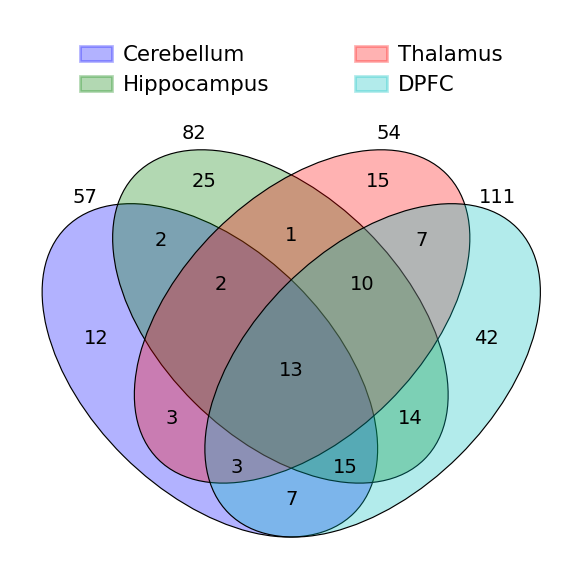

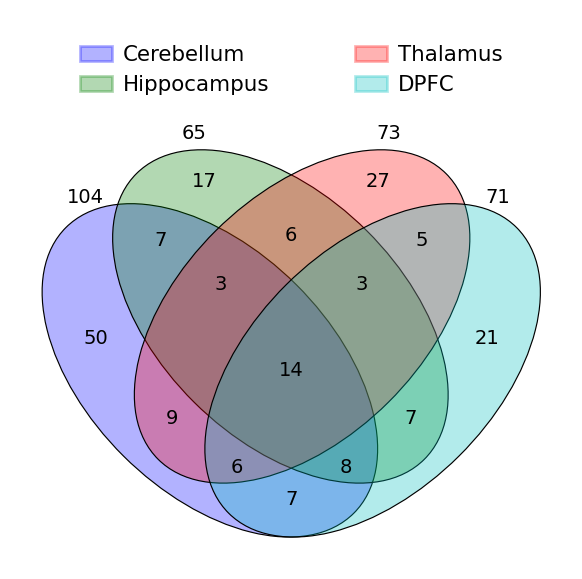

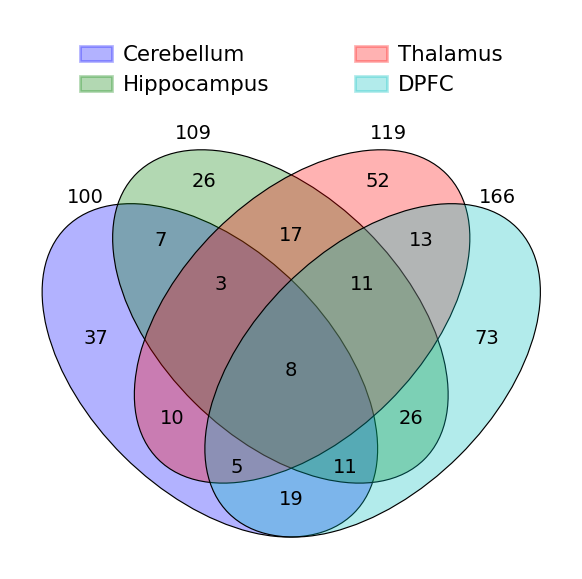

In [27]:
from venny4py.venny4py import venny4py

regions = ['Cerebellum', 'Hippocampus', 'Thalamus', 'DPFC']
trends = ['increasing', 'decreasing', 'other']

for trend in trends:
    venn_sets = {
        region: set(parkinson_gene_list_up[region].loc[parkinson_gene_list_up[region]['Trend'] == trend, 'Gene'].unique())
        for region in regions
    }
    print(f"Venn diagram for Down-regulated Parkinson's genes - {trend} trend")
    venny4py(sets=venn_sets)


Venn diagram for Up-regulated Parkinson's genes across regions (ignoring trend)
Venn diagram for Down-regulated Parkinson's genes across regions (ignoring trend)


"\nfrom venny4py.venny4py import venny4py\n\nsets = {\n    'Set2': set(ad_up),\n    'Set3': set(ad_down),\n}\nvenny4py(sets=sets)\n"

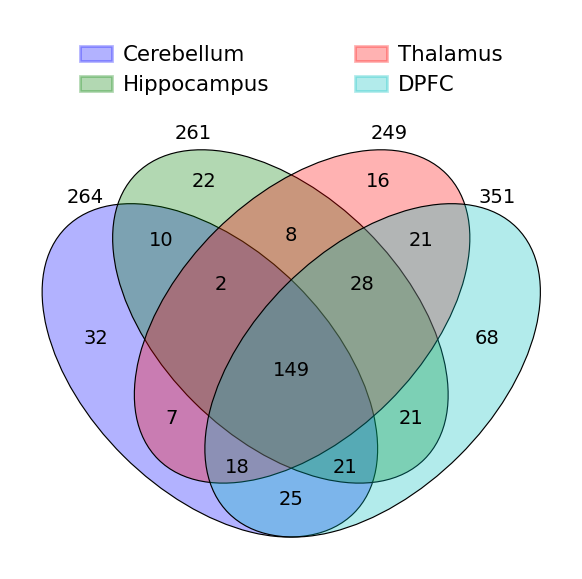

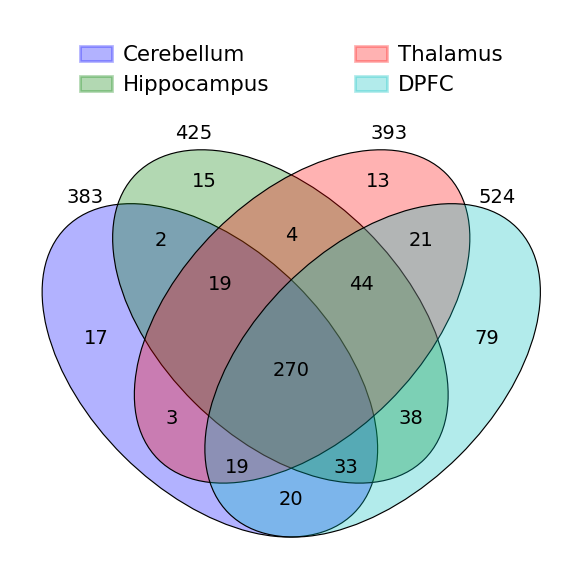

In [28]:
from venny4py.venny4py import venny4py

regions = ['Cerebellum', 'Hippocampus', 'Thalamus', 'DPFC']

venn_sets_up = {
    region: set(parkinson_gene_list_up[region]['Accession'].unique())
    for region in regions
}

print("Venn diagram for Up-regulated Parkinson's genes across regions (ignoring trend)")
venny4py(sets=venn_sets_up)


venn_sets_down = {
    region: set(parkinson_gene_list_down[region]['Accession'].unique())
    for region in regions
}

print("Venn diagram for Down-regulated Parkinson's genes across regions (ignoring trend)")
venny4py(sets=venn_sets_down)
'''
from venny4py.venny4py import venny4py

sets = {
    'Set2': set(ad_up),
    'Set3': set(ad_down),
}
venny4py(sets=sets)
'''

In [ ]:
from google.colab import files
import pandas as pd
import io

# Upload file
uploaded = files.upload()

# Read with proper encoding
file_name = next(iter(uploaded))
try:
    ad_429 = pd.read_csv(io.BytesIO(uploaded[file_name]), encoding='latin1')  # or 'ISO-8859-1'
    print(f"Successfully loaded {file_name}")
    print("Data preview:")
    display(ad_429.head())
except UnicodeDecodeError:
    print("""
    Still encountering errors? Try:
    1. Different encodings: 'utf-16', 'cp1252'
    2. Check CSV delimiters
    3. Verify file integrity
    """)


Saving AD-429_plasma_proteins.csv to AD-429_plasma_proteins (2).csv
Successfully loaded AD-429_plasma_proteins (2).csv
Data preview:


,Down-regulated in AD / early AD / MCI,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,Up-regulated in AD / early AD / MCI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Protein_name,Gene_name,Uniprot_ID,Olink_ID,Full_protein_name,Biological_category_1,Biological_category_2,AD_Estimate,AD_FDR_P_value,Literature_1,Literature_2,Literature_3,Literature_4,Literature_5,Literature_6
3,LYN,LYN,P07948,OID00715,Tyrosine-protein kinase Lyn (EC 2.7.10.2) (Lck...,Oncology,NaN,-1.481218233,2.82E-21,"Sattlecker, Martina, et al. ""Alzheimer's disea...",NaN,NaN,NaN,NaN,NaN
4,CD69,CD69,Q07108,OID01467,Early activation antigen CD69 (Activation indu...,Development,NaN,-1.531072132,5.22E-21,"Stieler, Jens T., et al. ""Impairment of mitoge...",NaN,NaN,NaN,NaN,NaN


In [ ]:
ad_429.columns = ad_429.iloc[2]
ad_429.head()

2,Protein_name,Gene_name,Uniprot_ID,Olink_ID,Full_protein_name,Biological_category_1,Biological_category_2,AD_Estimate,AD_FDR_P_value,Literature_1,Literature_2,Literature_3,Literature_4,Literature_5,Literature_6
0,Up-regulated in AD / early AD / MCI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Protein_name,Gene_name,Uniprot_ID,Olink_ID,Full_protein_name,Biological_category_1,Biological_category_2,AD_Estimate,AD_FDR_P_value,Literature_1,Literature_2,Literature_3,Literature_4,Literature_5,Literature_6
3,LYN,LYN,P07948,OID00715,Tyrosine-protein kinase Lyn (EC 2.7.10.2) (Lck...,Oncology,NaN,-1.481218233,2.82E-21,"Sattlecker, Martina, et al. ""Alzheimer's disea...",NaN,NaN,NaN,NaN,NaN
4,CD69,CD69,Q07108,OID01467,Early activation antigen CD69 (Activation indu...,Development,NaN,-1.531072132,5.22E-21,"Stieler, Jens T., et al. ""Impairment of mitoge...",NaN,NaN,NaN,NaN,NaN


In [ ]:
ad_429 = ad_429.drop([0, 1, 2])
ad_429.head()

2,Protein_name,Gene_name,Uniprot_ID,Olink_ID,Full_protein_name,Biological_category_1,Biological_category_2,AD_Estimate,AD_FDR_P_value,Literature_1,Literature_2,Literature_3,Literature_4,Literature_5,Literature_6
3,LYN,LYN,P07948,OID00715,Tyrosine-protein kinase Lyn (EC 2.7.10.2) (Lck...,Oncology,NaN,-1.481218233,2.82E-21,"Sattlecker, Martina, et al. ""Alzheimer's disea...",NaN,NaN,NaN,NaN,NaN
4,CD69,CD69,Q07108,OID01467,Early activation antigen CD69 (Activation indu...,Development,NaN,-1.531072132,5.22E-21,"Stieler, Jens T., et al. ""Impairment of mitoge...",NaN,NaN,NaN,NaN,NaN
5,EIF4G1,EIF4G1,Q04637,OID00976,Eukaryotic translation initiation factor 4 gam...,Immune response,NaN,-1.395597264,5.44E-21,NaN,NaN,NaN,NaN,NaN,NaN
6,PLXNA4,PLXNA4,Q9HCM2,OID00982,Plexin-A4,Immune response,NaN,-1.476181419,1.10E-20,NaN,NaN,NaN,NaN,NaN,NaN
7,SNAP29,SNAP29,O95721,OID01439,Synaptosomal-associated protein 29 (SNAP-29) (...,Development,NaN,-1.39664952,3.61E-20,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
ad_429 = ad_429.reset_index(drop=True)
ad_429.head()

2,Protein_name,Gene_name,Uniprot_ID,Olink_ID,Full_protein_name,Biological_category_1,Biological_category_2,AD_Estimate,AD_FDR_P_value,Literature_1,Literature_2,Literature_3,Literature_4,Literature_5,Literature_6
0,LYN,LYN,P07948,OID00715,Tyrosine-protein kinase Lyn (EC 2.7.10.2) (Lck...,Oncology,NaN,-1.481218233,2.82E-21,"Sattlecker, Martina, et al. ""Alzheimer's disea...",NaN,NaN,NaN,NaN,NaN
1,CD69,CD69,Q07108,OID01467,Early activation antigen CD69 (Activation indu...,Development,NaN,-1.531072132,5.22E-21,"Stieler, Jens T., et al. ""Impairment of mitoge...",NaN,NaN,NaN,NaN,NaN
2,EIF4G1,EIF4G1,Q04637,OID00976,Eukaryotic translation initiation factor 4 gam...,Immune response,NaN,-1.395597264,5.44E-21,NaN,NaN,NaN,NaN,NaN,NaN
3,PLXNA4,PLXNA4,Q9HCM2,OID00982,Plexin-A4,Immune response,NaN,-1.476181419,1.10E-20,NaN,NaN,NaN,NaN,NaN,NaN
4,SNAP29,SNAP29,O95721,OID01439,Synaptosomal-associated protein 29 (SNAP-29) (...,Development,NaN,-1.39664952,3.61E-20,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
ad_429['regulation'] = pd.cut(
    ad_429['AD_Estimate'].astype(float),
    bins=[-float('inf'), 0, float('inf')],
    labels=['DOWN', 'UP']
)
ad_429[['AD_Estimate', 'regulation']].head()

2,AD_Estimate,regulation
0,-1.481218233,DOWN
1,-1.531072132,DOWN
2,-1.395597264,DOWN
3,-1.476181419,DOWN
4,-1.39664952,DOWN


In [ ]:
ad_total = ad_429['Gene_name'].tolist()
ad_up = ad_429[ad_429['regulation'] == 'UP']['Gene_name'].tolist()
ad_down = ad_429[ad_429['regulation'] == 'DOWN']['Gene_name'].tolist()

print(len(ad_total))
print(len(ad_up))
print(len(ad_down))

429
61
368


In [ ]:
stage_columns = ['22week_Avg', '26week_Avg', '1year_Avg', '2year_Avg', '4year_Avg', '22year_Avg', '35year_Avg', '47year_Avg', '82year_Avg']
brain_regions = {'Cerebellum': cerebellum_df,
                 'Hippocampus': hippocampus_df,
                 'Thalamus': thalamus_df,
                 'DPFC': dpfc_df}

gene_list = ad_up

ad_genes_dataset = []
for region, df in trend_dfs.items():
    ad_genes_dataset += df[df['Gene'].isin(gene_list)]['Gene'].tolist()
ad_genes_dataset = list(set(ad_genes_dataset))  # Unique accessions for PD genes
print(ad_genes_dataset)
print(len(ad_genes_dataset))

#14/61, 226/368, 240/429

['SCG2', 'HSPB6', 'DCN', 'PTX3', 'TNC', 'PRSS2', 'SNCG', 'CX3CL1', 'SMOC1', 'CHL1', 'CLSTN2', 'FAM3B', 'TFRC', 'NCS1']
14


In [ ]:
gene_list = ad_up

region_increasing = {}
region_decreasing = {}
region_other = {}

for region_name, region_df in trend_dfs.items():
    filtered_genes = region_df[
        (region_df['Gene'].isin(gene_list)) &
        (region_df['Trend'] == 'increasing')
    ]['Gene'].unique().tolist()

    region_increasing[region_name] = filtered_genes

for region_name, region_df in trend_dfs.items():
    filtered_genes = region_df[
        (region_df['Gene'].isin(gene_list)) &
        (region_df['Trend'] == 'decreasing')
    ]['Gene'].unique().tolist()
    region_decreasing[region_name] = filtered_genes

for region_name, region_df in trend_dfs.items():
    filtered_genes = region_df[
        (region_df['Gene'].isin(gene_list)) &
        (region_df['Trend'] == 'other')
    ]['Gene'].unique().tolist()
    region_other[region_name] = filtered_genes

print("Increasing genes in gene_list by brain region:")
for region, genes in region_increasing.items():
    print(f"\n**{region}**:{len(genes)}")
    if genes:
        print(f"  - {', '.join(genes)} ({len(genes)} genes)")
    else:
        print("  - No increasing genes found")

print("\nDECREASING TREND GENES IN gene_list:")
for region, genes in region_decreasing.items():
    print(f"\n{region}:{len(genes)}")
    print(f"  {genes} ({len(genes)} genes)" if genes else "  No decreasing genes")

print("\n\nOTHER TREND GENES IN gene_list:")
for region, genes in region_other.items():
    print(f"\n{region}:{len(genes)}")
    print(f"  {genes} ({len(genes)} genes)" if genes else "  No other trend genes")


unique_genes = set()
for genes in region_decreasing.values():
    unique_genes.update(genes)  # Add all genes from each region

unique_genes = sorted(list(unique_genes))

print(f"Unique increasing genes across all regions ({len(unique_genes)} total):")
print(unique_genes)



Increasing genes in gene_list by brain region:

**Cerebellum**:3
  - SNCG, CHL1, NCS1 (3 genes)

**Hippocampus**:2
  - SNCG, FAM3B (2 genes)

**Thalamus**:4
  - SNCG, SCG2, HSPB6, PRSS2 (4 genes)

**DPFC**:3
  - SNCG, SCG2, HSPB6 (3 genes)

DECREASING TREND GENES IN gene_list:

Cerebellum:5
  ['TNC', 'DCN', 'SMOC1', 'TFRC', 'PRSS2'] (5 genes)

Hippocampus:3
  ['TFRC', 'CHL1', 'SMOC1'] (3 genes)

Thalamus:4
  ['TNC', 'CHL1', 'TFRC', 'SMOC1'] (4 genes)

DPFC:7
  ['TNC', 'CHL1', 'TFRC', 'NCS1', 'PRSS2', 'SMOC1', 'PTX3'] (7 genes)


OTHER TREND GENES IN gene_list:

Cerebellum:1
  ['SCG2'] (1 genes)

Hippocampus:4
  ['TNC', 'PTX3', 'NCS1', 'SCG2'] (4 genes)

Thalamus:3
  ['NCS1', 'CLSTN2', 'FAM3B'] (3 genes)

DPFC:2
  ['DCN', 'CX3CL1'] (2 genes)
Unique increasing genes across all regions (8 total):
['CHL1', 'DCN', 'NCS1', 'PRSS2', 'PTX3', 'SMOC1', 'TFRC', 'TNC']


In [ ]:
for region, df in trend_dfs.items():
    if 'Trend' in df.columns:
        counts = df['Trend'].value_counts()
        print(f"{region}:")
        print(f"  increasing: {counts.get('increasing', 0)}")
        print(f"  decreasing: {counts.get('decreasing', 0)}")
        print(f"  other: {counts.get('other', 0)}")
    else:
        print(f"{region}: No 'increasing' trend column found.")


Cerebellum:
  increasing: 1216
  decreasing: 1489
  other: 1714
Hippocampus:
  increasing: 1159
  decreasing: 1319
  other: 1905
Thalamus:
  increasing: 807
  decreasing: 1327
  other: 1930
DPFC:
  increasing: 1518
  decreasing: 1514
  other: 2601


In [ ]:
!pip install gseapy pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.8/590.8 kB 7.7 MB/s eta 0:00:00



--- Cerebellum: Increasing Genes ---
          Gene_set                           Term  Overlap       P-value  \
0  KEGG_2021_Human      Oxidative phosphorylation   63/133  2.670168e-41   
1  KEGG_2021_Human             Huntington disease   89/306  2.467716e-37   
2  KEGG_2021_Human        Diabetic cardiomyopathy   71/203  9.157766e-36   
3  KEGG_2021_Human  Pathways of neurodegeneration  107/475  1.014722e-33   
4  KEGG_2021_Human              Parkinson disease   75/249  1.011050e-32   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0      7.903698e-39            0                     0   14.798244   
1      3.652220e-35            0                     0    6.847061   
2      9.035663e-34            0                     0    8.877140   
3      7.508940e-32            0                     0    4.893811   
4      5.985418e-31            0                     0    7.122969   

   Combined Score                                              Genes  
0     1382.50

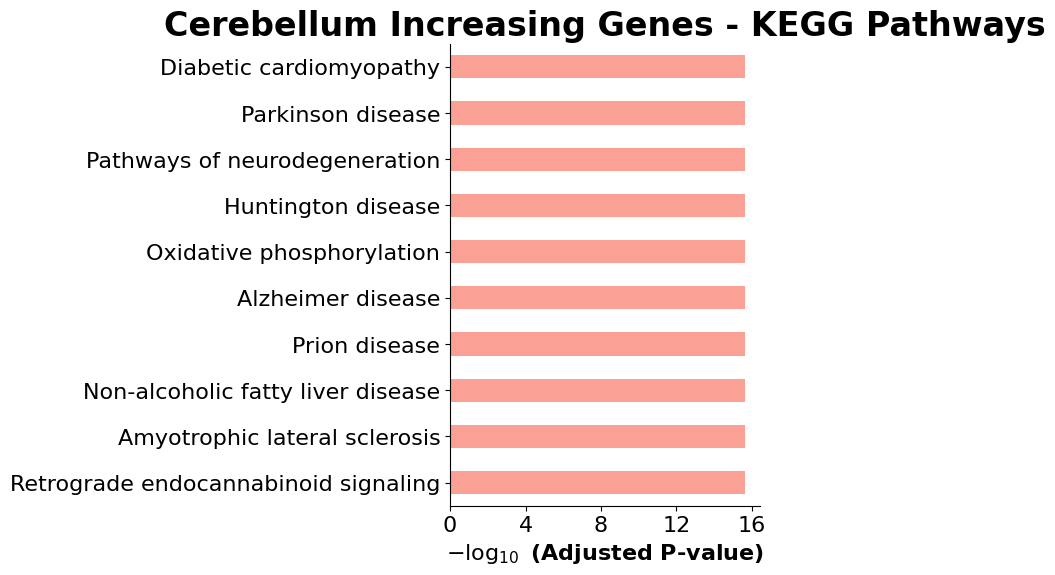

In [ ]:
import gseapy as gp
from gseapy.plot import barplot

def run_enrichment(gene_list, gene_set='KEGG_2021_Human'):
    """Run enrichment analysis using g:Profiler."""
    if not gene_list:
        return None
    try:
        enr = gp.enrichr(gene_list=gene_list,
                         gene_sets=gene_set,
                         organism='human',
                         cutoff=0.05  # Adjust p-value threshold
                        )
        return enr.results
    except Exception as e:
        print(f"Enrichment failed: {e}")
        return None

# Store enrichment results
increasing_enrichment = {}
decreasing_enrichment = {}

for region, df in trend_dfs.items():
    # Extract increasing/decreasing genes
    increasing_genes = df[df['Trend'] == 'increasing']['Gene'].dropna().tolist()
    decreasing_genes = df[df['Trend'] == 'decreasing']['Gene'].dropna().tolist()

    # Run enrichment
    increasing_enrichment[region] = run_enrichment(increasing_genes)
    decreasing_enrichment[region] = run_enrichment(decreasing_genes)

    # Print top terms
    print(f"\n--- {region}: Increasing Genes ---")
    if increasing_enrichment[region] is not None:
        print(increasing_enrichment[region].head())

    print(f"\n--- {region}: Decreasing Genes ---")
    if decreasing_enrichment[region] is not None:
        print(decreasing_enrichment[region].head())

# Example: Plot top enriched terms for Cerebellum's increasing genes
if increasing_enrichment['Cerebellum'] is not None:
    barplot(increasing_enrichment['Cerebellum'],
            title='Cerebellum Increasing Genes - KEGG Pathways',
            cutoff=0.05)


# this is the proof

In [ ]:
uploaded = files.upload()
filename = list(uploaded.keys())[0]

with open(filename, 'r') as f:
    lines = [line.strip() for line in f if line.strip()]

if len(lines) == 1:
    gene_list = lines[0].split('\t')
else:
    gene_list = lines

print(f"Number of genes: {len(gene_list)}")
print(gene_list[:10])  # Show first 10 genes as a sample

# If you want to skip the first two entries (e.g., headers)
gene_list = gene_list[2:]
print(f"Number of genes after removing first two: {len(gene_list)}")
print(gene_list[:10])

Saving KEGG_CALCIUM_SIGNALING_PATHWAY.v2024.1.Hs.gmt to KEGG_CALCIUM_SIGNALING_PATHWAY.v2024.1.Hs.gmt
Number of genes: 180
['KEGG_CALCIUM_SIGNALING_PATHWAY', 'https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/KEGG_CALCIUM_SIGNALING_PATHWAY', 'ADCY1', 'ADCY2', 'ADCY3', 'ADCY4', 'ADCY7', 'ADCY8', 'ADCY9', 'ADORA2A']
Number of genes after removing first two: 178
['ADCY1', 'ADCY2', 'ADCY3', 'ADCY4', 'ADCY7', 'ADCY8', 'ADCY9', 'ADORA2A', 'ADORA2B', 'ADRA1A']


In [ ]:
notch_genes_dataset = []
for region, df in trend_dfs.items():
    df = df[df['Trend'] == 'increasing']
    notch_genes_dataset += df[df['Gene'].isin(gene_list)]['Gene'].tolist()
notch_genes_dataset = list(set(notch_genes_dataset))  # Unique accessions for PD genes
print(notch_genes_dataset)
print(len(notch_genes_dataset))
no_of_genes = len(gene_list)

['VDAC2', 'SPHK2', 'PHKB', 'CHP1', 'VDAC3', 'CAMK4', 'PPID', 'PTK2B', 'CAMK2B', 'ATP2A2', 'RYR2', 'CAMK2A', 'GRM1', 'PRKCB', 'PDE1B', 'CAMK2G', 'SLC25A5', 'ITPR2', 'CACNA1E', 'PLCD1', 'P2RX7', 'PLCB3', 'VDAC1', 'GNAL', 'PRKCG', 'PLCB4', 'GNA11', 'PPP3R1', 'PLCD3', 'PDE1C', 'EDNRB', 'GRIN1', 'CD38', 'ATP2B4', 'EGFR', 'PDGFRB', 'SLC25A4', 'PHKA1', 'PPP3CA', 'PRKCA', 'GRIN2A', 'GNAS', 'CAMK2D', 'CACNA1B', 'PDE1A', 'ITPR1', 'ADCY8', 'NOS1', 'ADCY9', 'ATP2B3', 'ATP2B1', 'MYLK', 'CACNA1D']
53



Analyzing Cerebellum


<ipython-input-31-445b16162b4e>:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


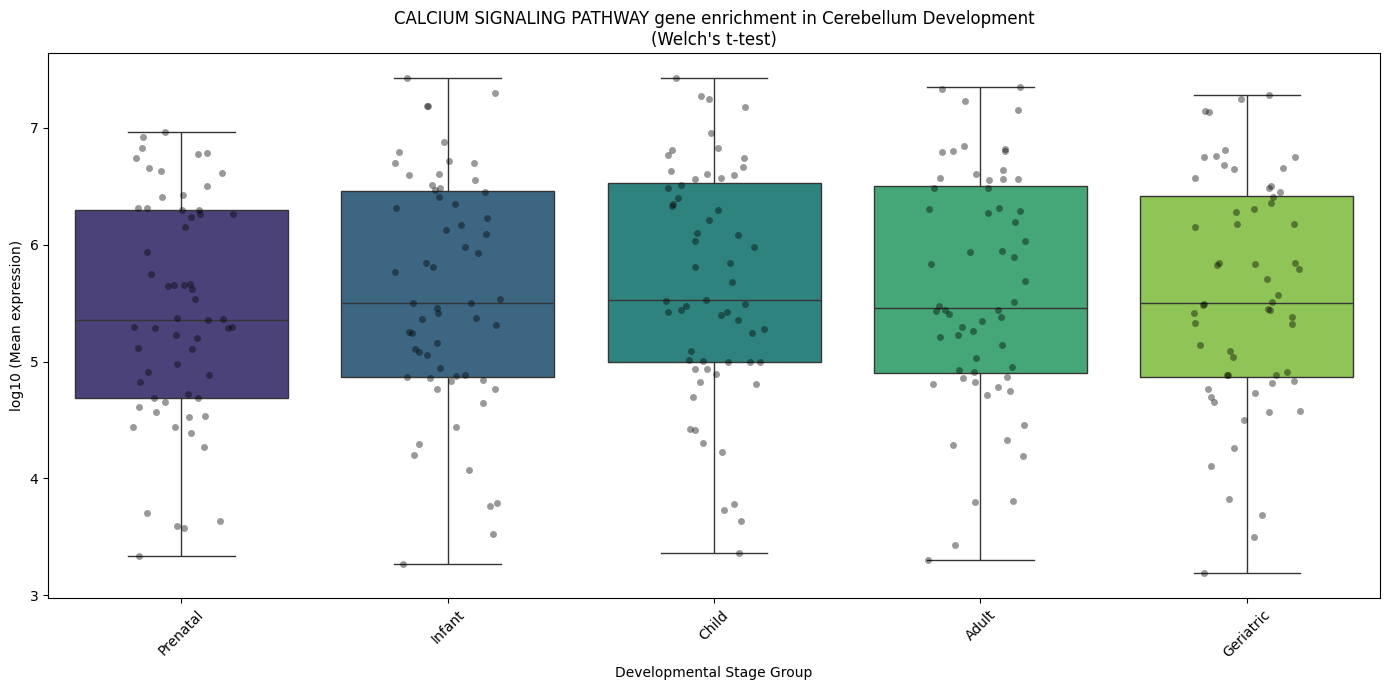


Analyzing Hippocampus


<ipython-input-31-445b16162b4e>:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


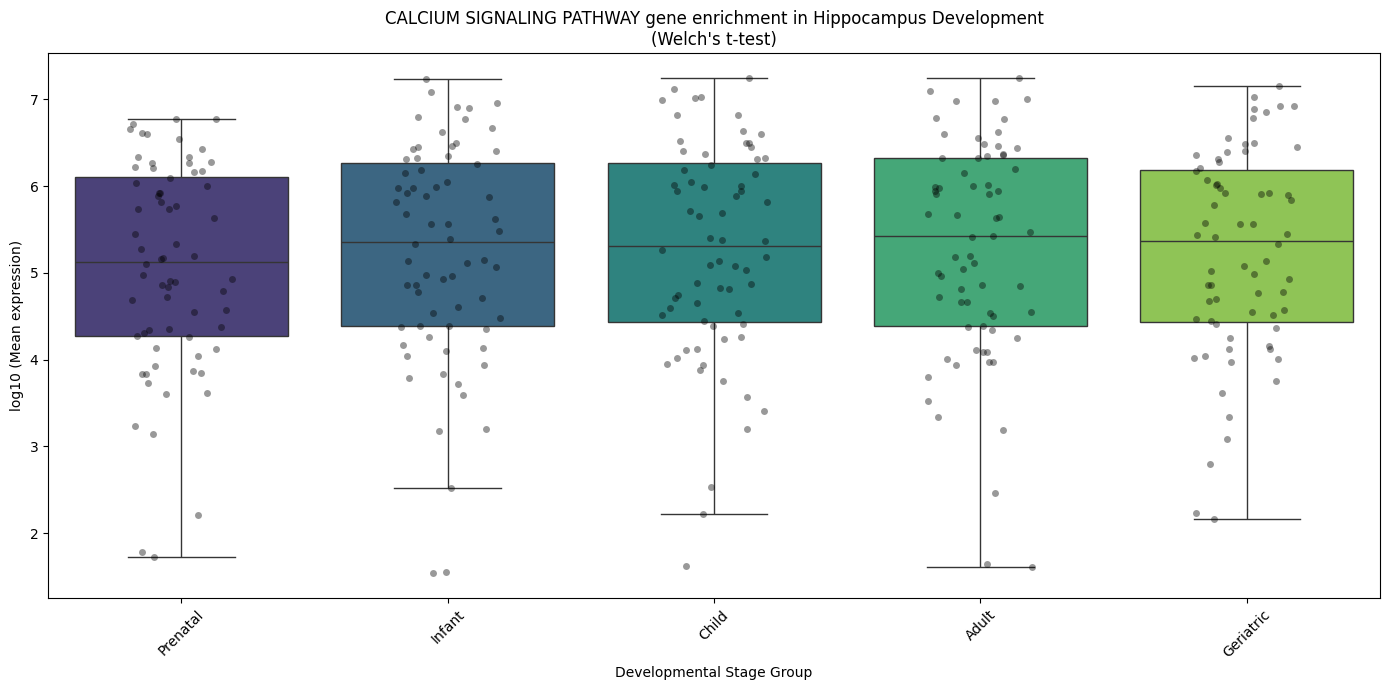


Analyzing DPFC


<ipython-input-31-445b16162b4e>:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


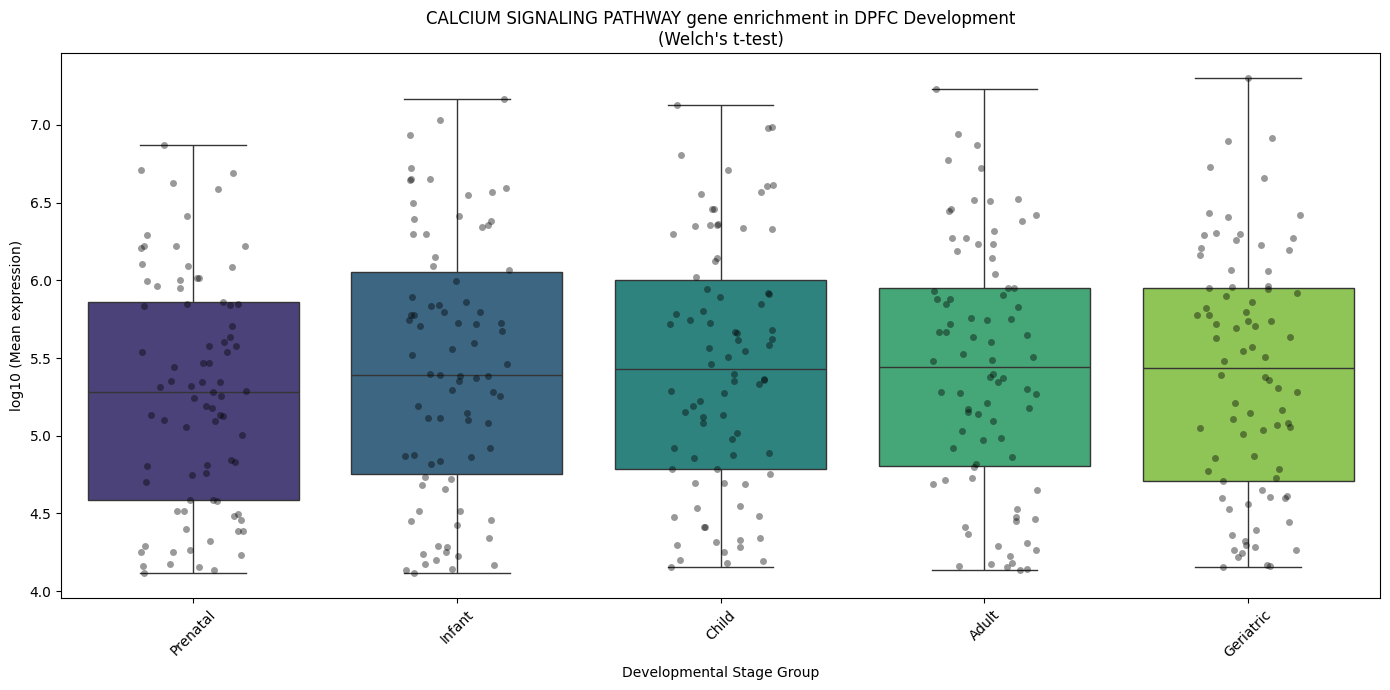


Analyzing Thalamus


<ipython-input-31-445b16162b4e>:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


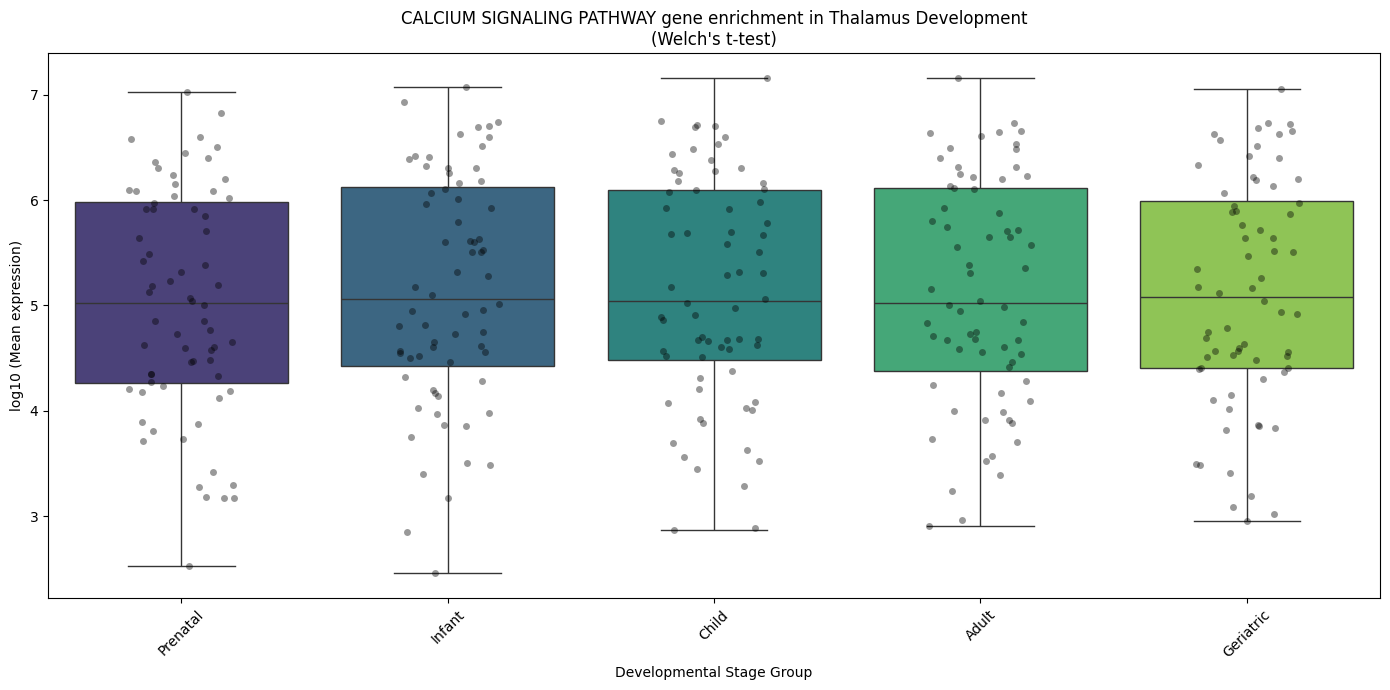



📊 FINAL RESULTS

Region: Cerebellum
Genes found: ['ITPR1', 'ATP2B2', 'ATP2B1', 'ATP2B4', 'VDAC1', 'ATP2B3', 'VDAC2', 'ATP2A2', 'SLC8A2', 'CAMK2B', 'VDAC3', 'CALM2', 'PPP3CA', 'SLC25A5', 'GNAQ', 'CAMK4', 'CAMK2D', 'SLC25A4', 'PRKCA', 'SLC25A6', 'ATP2A3', 'GNA11', 'PPP3CB', 'CAMK2A', 'CAMK2G', 'GNAS', 'PRKCG', 'PRKCB', 'PLCD1', 'PRKACB', 'PRKACA', 'GRM1', 'PLCB4', 'PLCG1', 'PLCD3', 'CACNA1A', 'PTK2B', 'SLC8A1', 'PLCB1', 'PDE1A', 'RYR2', 'EGFR', 'CHP1', 'PPP3R1', 'ADCY1', 'PDE1C', 'ITPKA', 'PLCB3', 'MYLK', 'PHKB', 'GRIN1', 'PDE1B', 'NOS1', 'PHKA1', 'PPID', 'CACNA1B', 'CD38']
Duplicates (isoforms): ['ITPR1', 'ATP2B4', 'GNAS']
Unique genes: 57/178
Significant comparisons:
Data points per group:
Stage_Group
Prenatal     60
Infant       60
Child        60
Adult        60
Geriatric    60
Name: count, dtype: int64

Region: Hippocampus
Genes found: ['SLC8A1', 'GRIN1', 'RYR2', 'ADCY2', 'GNA11', 'MYLK', 'GNAS', 'PLCB1', 'CACNA1A', 'SLC25A5', 'SLC25A6', 'PLCD3', 'PLCD1', 'PRKCB', 'VDAC3', 'CAMK2D

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Configuration - MUST SET THESE VALUES
# -------------------------------------------------
stage_groups = {
    'Prenatal': ['22week', '26week'],
    'Infant': ['1year', '2year'],
    'Child': ['4year'],
    'Adult': ['22year', '35year', '47year'],
    'Geriatric': ['82year']
}

PATHWAY = "CALCIUM SIGNALING PATHWAY"
regions = ['Cerebellum', 'Hippocampus', 'DPFC', 'Thalamus']
stage_columns = ['22week_Avg', '26week_Avg', '1year_Avg', '2year_Avg',
                '4year_Avg', '22year_Avg', '35year_Avg', '47year_Avg', '82year_Avg']

# YOU MUST DEFINE THESE IN YOUR ENVIRONMENT:
# brain_regions = {...}  # Dictionary of DataFrames for each region
# gene_list = [...]      # List of genes in the spliceosome pathway
# no_of_genes = ...      # Total genes in the pathway

# 2. Analysis Function
# -------------------------------------------------
def analyze_region(region, brain_regions, gene_list, no_of_genes):
    try:
        # Load data
        df = brain_regions[region].copy()
        notch_df = df[df['Gene'].isin(gene_list)].copy()

        if notch_df.empty:
            print(f"\n⚠️ No genes found in {region} - skipping")
            return None

        # Melt to long format
        melted = notch_df.melt(
            id_vars=['Gene', 'Accession'],
            value_vars=stage_columns,
            var_name='Stage',
            value_name='Expression'
        )

        # Clean and process
        melted['Stage'] = melted['Stage'].str.replace('_Avg', '')
        melted['Stage_Group'] = melted['Stage'].apply(
            lambda x: next((k for k, v in stage_groups.items() if x in v), 'Unknown')
        )

        # Average and transform
        mean_per_gene_group = (
            melted.groupby(['Gene', 'Accession', 'Stage_Group'])['Expression']
            .mean()
            .reset_index()
        )
        mean_per_gene_group['Log10_Expression'] = np.log10(mean_per_gene_group['Expression'])

        # Analysis parameters
        groups_order = ['Prenatal', 'Infant', 'Child', 'Adult', 'Geriatric']
        comparisons = (
            [(groups_order[i], groups_order[i+1]) for i in range(len(groups_order)-1)]
            + [('Prenatal', 'Geriatric')]
        )

        # Welch's t-tests
        significant_comparisons = []
        for g1, g2 in comparisons:
            data1 = mean_per_gene_group[mean_per_gene_group['Stage_Group'] == g1]['Log10_Expression']
            data2 = mean_per_gene_group[mean_per_gene_group['Stage_Group'] == g2]['Log10_Expression']

            if len(data1) > 1 and len(data2) > 1:
                _, p_val = stats.ttest_ind(data1, data2, equal_var=False)
                if p_val < 0.05:
                    significant_comparisons.append({
                        'groups': (g1, g2),
                        'p_val': p_val,
                        'symbol': get_significance(p_val)
                    })

        # Visualization
        plt.figure(figsize=(14, 7))
        ax = sns.boxplot(
            x='Stage_Group',
            y='Log10_Expression',
            data=mean_per_gene_group,
            order=groups_order,
            palette='viridis',
            showfliers=False
        )
        sns.stripplot(
            x='Stage_Group',
            y='Log10_Expression',
            data=mean_per_gene_group,
            order=groups_order,
            color='black',
            alpha=0.4,
            jitter=0.2,
            size=5,
            ax=ax
        )

        # Annotations
        y_max = mean_per_gene_group['Log10_Expression'].max() + 0.5
        for comp in significant_comparisons:
            g1, g2 = comp['groups']
            x1 = groups_order.index(g1)
            x2 = groups_order.index(g2)
            ax.plot([x1, x2], [y_max, y_max], color='k', lw=1)
            ax.text((x1+x2)/2, y_max + 0.1, comp['symbol'], ha='center', va='bottom')
            y_max += 0.5

        plt.title(f'{PATHWAY} gene enrichment in {region} Development\n(Welch\'s t-test)')
        plt.xlabel('Developmental Stage Group')
        plt.ylabel('log10 (Mean expression)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Prepare results
        unique_genes = notch_df['Gene'].unique().tolist()
        duplicate_genes = notch_df[notch_df.duplicated('Gene', keep=False)]['Gene'].unique().tolist()
        count_per_group = mean_per_gene_group['Stage_Group'].value_counts().reindex(groups_order).fillna(0).astype(int)

        return {
            'region': region,
            'genes': unique_genes,
            'duplicates': duplicate_genes,
            'significant_comps': significant_comparisons,
            'counts': count_per_group,
            'total_genes': f"{len(unique_genes)}/{no_of_genes}"
        }

    except KeyError as e:
        print(f"⚠️ Missing data for {region}: {str(e)}")
        return None
    except Exception as e:
        print(f"⚠️ Error in {region}: {str(e)}")
        return None

# 3. Main Execution
# -------------------------------------------------
def get_significance(p_val):
    if p_val < 0.0001: return '****'
    elif p_val < 0.001: return '***'
    elif p_val < 0.01: return '**'
    elif p_val < 0.05: return '*'
    else: return 'ns'

if __name__ == "__main__":
    # Validate inputs
    if 'brain_regions' not in globals():
        raise NameError("❌ brain_regions not defined - load your data first")
    if 'gene_list' not in globals():
        raise NameError("❌ gene_list not defined - specify pathway genes")
    if 'no_of_genes' not in globals():
        raise NameError("❌ no_of_genes not defined - set pathway gene count")

    # Process all regions
    results = []
    for region in regions:
        print(f"\n{'='*40}\nAnalyzing {region}\n{'='*40}")
        result = analyze_region(region, brain_regions, gene_list, no_of_genes)
        if result:
            results.append(result)

    # Print consolidated results
    print("\n\n📊 FINAL RESULTS")
    for res in results:
        print(f"\n{'='*40}\nRegion: {res['region']}")
        print(f"Genes found: {res['genes']}")
        print(f"Duplicates (isoforms): {res['duplicates']}")
        print(f"Unique genes: {res['total_genes']}")
        print("Significant comparisons:")
        for comp in res['significant_comps']:
            print(f"  {comp['groups'][0]} vs {comp['groups'][1]}: "
                  f"p={comp['p_val']:.4f} ({comp['symbol']})")
        print("Data points per group:")
        print(res['counts'])
